In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model, load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from scipy import interpolate

In [3]:
# Load the saved latent vectors and encoder model
filepath = r'/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_model.h5'
latent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/latent_vectors.npy')
encoder = load_model(filepath)
#encoder = tf.keras.layers.TFSMLayer('encoder_model', call_endpoint='serving_default')
image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/image_data.npy')

In [4]:
"""
# Define decoder architecture
latent_dim = 64  # Must match encoder's latent_dim
latent_input = tf.keras.Input(shape=(latent_dim,))


# Improved decoder layers with more filters and BatchNormalization
x = Dense(28 * 28 * 128, activation='relu')(latent_input)
x = BatchNormalization()(x)
x = Reshape((28, 28, 128))(x)

x = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Final layer with tanh activation for better color reproduction
decoded_output = Conv2DTranspose(3, (3, 3), activation='tanh', padding='same')(x)

# Create and compile decoder model with a custom loss
decoder = Model(latent_input, decoded_output, name="decoder")
decoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='mse'  # Mean squared error for better image quality
)

# Train the decoder with more epochs and a smaller batch size
print("Training decoder...")
decoder.fit(
    latent_vectors,
    image_data,
    epochs=50,  # Increased epochs
    batch_size=32,  # Smaller batch size
    shuffle=True,
    validation_split=0.1
)


# Save the trained decoder
decoder.save('/content/drive/MyDrive/ML final project/Trained_models/decoder/decoder_model.h5')
"""

'\n# Define decoder architecture\nlatent_dim = 64  # Must match encoder\'s latent_dim\nlatent_input = tf.keras.Input(shape=(latent_dim,))\n\n\n# Improved decoder layers with more filters and BatchNormalization\nx = Dense(28 * 28 * 128, activation=\'relu\')(latent_input)\nx = BatchNormalization()(x)\nx = Reshape((28, 28, 128))(x)\n\nx = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding=\'same\', activation=\'relu\')(x)\nx = BatchNormalization()(x)\n\nx = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding=\'same\', activation=\'relu\')(x)\nx = BatchNormalization()(x)\n\nx = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding=\'same\', activation=\'relu\')(x)\nx = BatchNormalization()(x)\n\n# Final layer with tanh activation for better color reproduction\ndecoded_output = Conv2DTranspose(3, (3, 3), activation=\'tanh\', padding=\'same\')(x)\n\n# Create and compile decoder model with a custom loss\ndecoder = Model(latent_input, decoded_output, name="decoder")\ndecoder.compile(\n    opti

In [5]:
# WORKING
# Function to reconstruct images from latent vectors
def reconstruct_images(latent_vectors, num_images=5):
    reconstructed = decoder.predict(latent_vectors[:num_images])
    reconstructed = np.clip(reconstructed, 0, 1)

    # Display original vs reconstructed images
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image_data[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Function to interpolate between two images
def interpolate_images(latent_vector1, latent_vector2, num_steps=10):
    alphas = np.linspace(0, 1, num_steps)
    interpolated_vectors = []

    for alpha in alphas:
        interpolated_vector = (1 - alpha) * latent_vector1 + alpha * latent_vector2
        interpolated_vectors.append(interpolated_vector)

    interpolated_vectors = np.array(interpolated_vectors)
    interpolated_images = decoder.predict(interpolated_vectors)

    # Display interpolation results
    plt.figure(figsize=(15, 3))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(interpolated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [6]:
print(os.path.exists(filepath))

True


In [7]:

# WORKING
def get_color_examples(labels_df, latent_vectors, color_name, n=1):
    """Get latent vectors for eyes of a specific color"""
    color_indices = labels_df[labels_df['label'] == color_name].index[:n]
    return latent_vectors[color_indices]

def interpolate_color_sequence(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green', 'gray'], steps_between=10):
    """Create a sequence of interpolations between different eye colors"""
    # Get one example for each color
    color_vectors = [get_color_examples(labels_df, latent_vectors, color, 1)[0] for color in colors]

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    # Interpolate between consecutive colors
    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        # Create interpolation
        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)


        # Plot this interpolation sequence
        plt.subplot(len(colors)-1, 1, current_plot)
        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()





In [8]:
# Not WORKING
"""
if __name__ == "__main__":
    # Example usage
    print("Reconstructing sample images...")
    reconstruct_images(latent_vectors)

    print("\nInterpolating between two random images...")
    idx1, idx2 = np.random.randint(0, len(latent_vectors), 2)
    interpolate_images(latent_vectors[idx1], latent_vectors[idx2])

    # Load the labels
    labels_df = pd.read_csv('/content/drive/MyDrive/ML final project/datasets/iris_labels_full.csv')
    print("\nInterpolating between different eye colors...")
    interpolate_color_sequence(decoder, latent_vectors, labels_df)
"""

'\nif __name__ == "__main__":\n    # Example usage\n    print("Reconstructing sample images...")\n    reconstruct_images(latent_vectors)\n\n    print("\nInterpolating between two random images...")\n    idx1, idx2 = np.random.randint(0, len(latent_vectors), 2)\n    interpolate_images(latent_vectors[idx1], latent_vectors[idx2])\n\n    # Load the labels\n    labels_df = pd.read_csv(\'/content/drive/MyDrive/ML final project/datasets/iris_labels_full.csv\')\n    print("\nInterpolating between different eye colors...")\n    interpolate_color_sequence(decoder, latent_vectors, labels_df)\n'

In [9]:
!pip install tensorflow==2.11.0

In [10]:
!pip install colormath

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.cluster import KMeans
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

# Load the trained decoder and necessary data
filepath = r'/content/drive/MyDrive/ML final project/Trained_models/decoder/decoder_model2.h5'
decoder = load_model(filepath, custom_objects={'Conv2DTranspose': tf.keras.layers.Conv2DTranspose})
latent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/latent_vectors2.npy')
image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/image_data2.npy')


In [12]:
# WORKING
def reconstruct_images(latent_vectors, num_images=5):
    reconstructed = decoder.predict(latent_vectors[:num_images])
    reconstructed = np.clip(reconstructed, 0, 1)

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image_data[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

In [13]:
# WORKING
def get_color_examples(labels_df, latent_vectors, color_name, n=1):
    """Get latent vectors for eyes of a specific color"""
    color_indices = labels_df[labels_df['label'] == color_name].index[:n]
    return latent_vectors[color_indices]

def interpolate_color_sequence(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green'], steps_between=10):
    color_vectors = [get_color_examples(labels_df, latent_vectors, color, 1)[0] for color in colors]

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)

        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()

In [14]:
import random
# SOMEWHAT WORKING
def randomer_interpolater(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green'], steps_between=10):
    """Create a sequence of interpolations between different eye colors using random images"""

    color_vectors = []
    for color in colors:
        # Get indices of images for the current color
        color_indices = labels_df[labels_df['label'] == color].index

        # Randomly select one image from the color indices
        random_index = random.choice(color_indices)
        color_vectors.append(latent_vectors[random_index])

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    # Interpolate between consecutive colors
    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        # Create interpolation
        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)

        # Plot this interpolation sequence
        plt.subplot(len(colors)-1, 1, current_plot)
        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()

In [15]:
import cv2
# SOMEWHAT WORKING
def find_best_representative_images(image_data, labels_df, colors=['brown', 'blue', 'hazel', 'green']):
    """Finds the best representative image for each eye color class"""

    best_representatives = {}
    for color in colors:
        color_indices = labels_df[labels_df['label'] == color].index
        best_score = -1
        best_index = -1

        for index in color_indices:
            image = image_data[index]

            # Criteria 1: Centered Iris (using Hough Circle Transform)
            # Ensure the image is in the correct format (RGB) before converting to grayscale
            image = image.astype(np.uint8)  # Convert to 8-bit unsigned integer if necessary
            if image.ndim == 3 and image.shape[2] == 3:  # Check if the image is RGB
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                # If the image is not RGB, assume it's already grayscale
                gray = image

            circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)
            if circles is not None:
                center_score = 1  # Higher score if a circle (iris) is detected
            else:
                center_score = 0

            # Criteria 2: Color Clarity (using standard deviation of color channels)
            color_clarity_score = np.std(image)  # Higher standard deviation indicates more color variation

            # Combine scores (adjust weights as needed)
            score = 0.7 * center_score

            if score > best_score:
                best_score = score
                best_index = index

        best_representatives[color] = image_data[best_index]

    # Display the best representative images
    """
    plt.figure(figsize=(15, 3))
    for i, color in enumerate(colors):
        plt.subplot(1, len(colors), i + 1)
        plt.imshow(best_representatives[color])
        plt.title(color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    """

    return best_representatives

In [16]:
# BROKEN
def get_dominant_iris_color(image):
    """
    Extracts the dominant color of the iris using Hough Circles and KMeans clustering.
    """
    # Convert to grayscale and apply Hough Circle Transform to detect the iris
    image = image.astype(np.uint8)  # Convert to 8-bit unsigned integer if necessary
    if image.ndim == 3 and image.shape[2] == 3:  # Check if the image is RGB
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is not RGB, assume it's already grayscale
        gray = image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Extract the iris region using the detected circle
            x, y, r = i[0], i[1], i[2]
            iris_region = image[y - r:y + r, x - r:x + r]

            # Reshape the iris region for KMeans clustering
            pixels = iris_region.reshape((-1, 3))

            # Apply KMeans clustering to find the dominant color
            kmeans = KMeans(n_clusters=1)
            kmeans.fit(pixels)
            dominant_color = kmeans.cluster_centers_[0]

            return dominant_color  # Return the dominant color as an RGB array
    print("NO IRIS DETECTED")
    return None  # Return None if no iris is detected

In [17]:
# BROKEN

def apply_iris_color(base_image, target_image, color_to_apply):
    """
    Applies the extracted iris color to the target image using Hough Circles.
    """
    # Convert to grayscale and apply Hough Circle Transform to detect the iris
    base_image = base_image.astype(np.uint8)  # Convert to 8-bit unsigned integer if necessary
    if base_image.ndim == 3 and base_image.shape[2] == 3:  # Check if the image is RGB
        gray = cv2.cvtColor(base_image, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is not RGB, assume it's already grayscale
        gray = base_image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Extract the iris region using the detected circle
            x, y, r = i[0], i[1], i[2]
            iris_region = target_image[y - r:y + r, x - r:x + r]

            # Apply the extracted color to the iris region
            iris_region[:, :, :] = color_to_apply.astype(np.uint8)

    return target_image  # Return the modified target image

In [18]:
# BROKEN

def interpolate_and_apply_color_from_classes(base_image, image_data, labels_df, colors=['brown', 'blue', 'green', 'hazel'], steps_between=10):
    """
    Interpolates between dominant iris colors of different eye color classes and applies them to the base image.
    """
    # Get the best representative images for each color class
    best_representatives = find_best_representative_images(image_data, labels_df, colors)

    # Extract dominant colors from the representative images
    colors_to_apply = [get_dominant_iris_color(best_representatives[color]) for color in colors]

    base_image = best_representatives['brown']

    # Create target images (copies of the base image)
    target_images = [base_image.copy() for _ in range(len(colors))]

    # Call the main interpolation function
    interpolate_and_apply_color(base_image, target_images, colors_to_apply, steps_between)


def interpolate_and_apply_color(base_image, target_images, colors_to_apply, steps_between=10):
    """
    Interpolates between colors and applies them to the target images.
    """
    num_colors = len(colors_to_apply)

    plt.figure(figsize=(20, 4 * num_colors))

    for i, color_to_apply in enumerate(colors_to_apply):
        # Get dominant color of base image
        base_color = get_dominant_iris_color(base_image)

        # Convert colors to Lab color space for better interpolation
        base_color_lab = convert_color(sRGBColor(*base_color / 255.0), LabColor)
        target_color_lab = convert_color(sRGBColor(*color_to_apply / 255.0), LabColor)

        # Interpolate between colors in Lab space
        interpolated_colors_lab = [
            base_color_lab + (target_color_lab - base_color_lab) * alpha
            for alpha in np.linspace(0, 1, steps_between)
        ]

        # Convert back to RGB
        interpolated_colors_rgb = [
            convert_color(color_lab, sRGBColor).get_value_tuple() * 255.0
            for color_lab in interpolated_colors_lab
        ]

        # Apply interpolated colors to target images
        for j, interpolated_color in enumerate(interpolated_colors_rgb):
            modified_image = apply_iris_color(base_image, target_images[i].copy(), interpolated_color)

            # Plot the modified image
            plt.subplot(num_colors, steps_between, i * steps_between + j + 1)
            plt.imshow(modified_image)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

Reconstructing sample images...
1/1 [==============================] - 0s 396ms/step


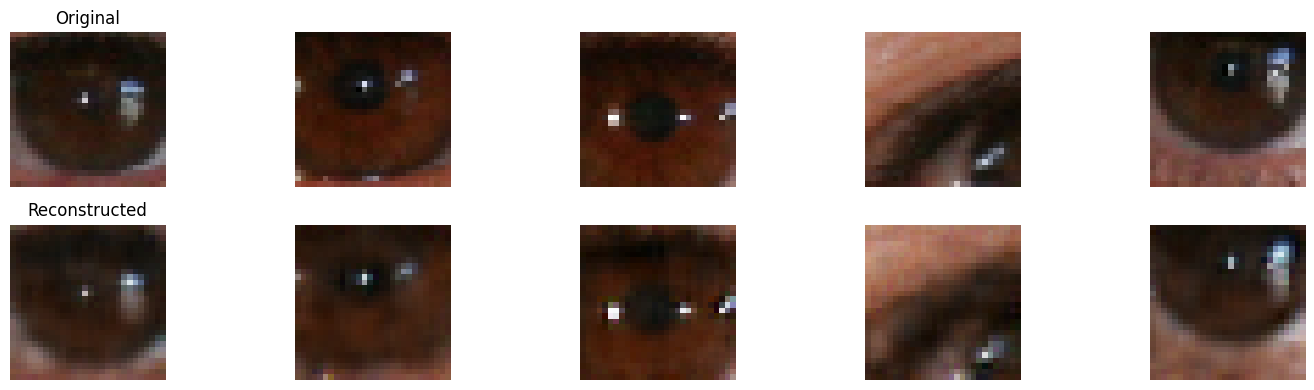


Interpolating between different eye colors...
Interpolating from brown to blue...
1/1 [==============================] - 0s 127ms/step
Interpolating from blue to hazel...
1/1 [==============================] - 0s 187ms/step
Interpolating from hazel to green...
1/1 [==============================] - 0s 214ms/step


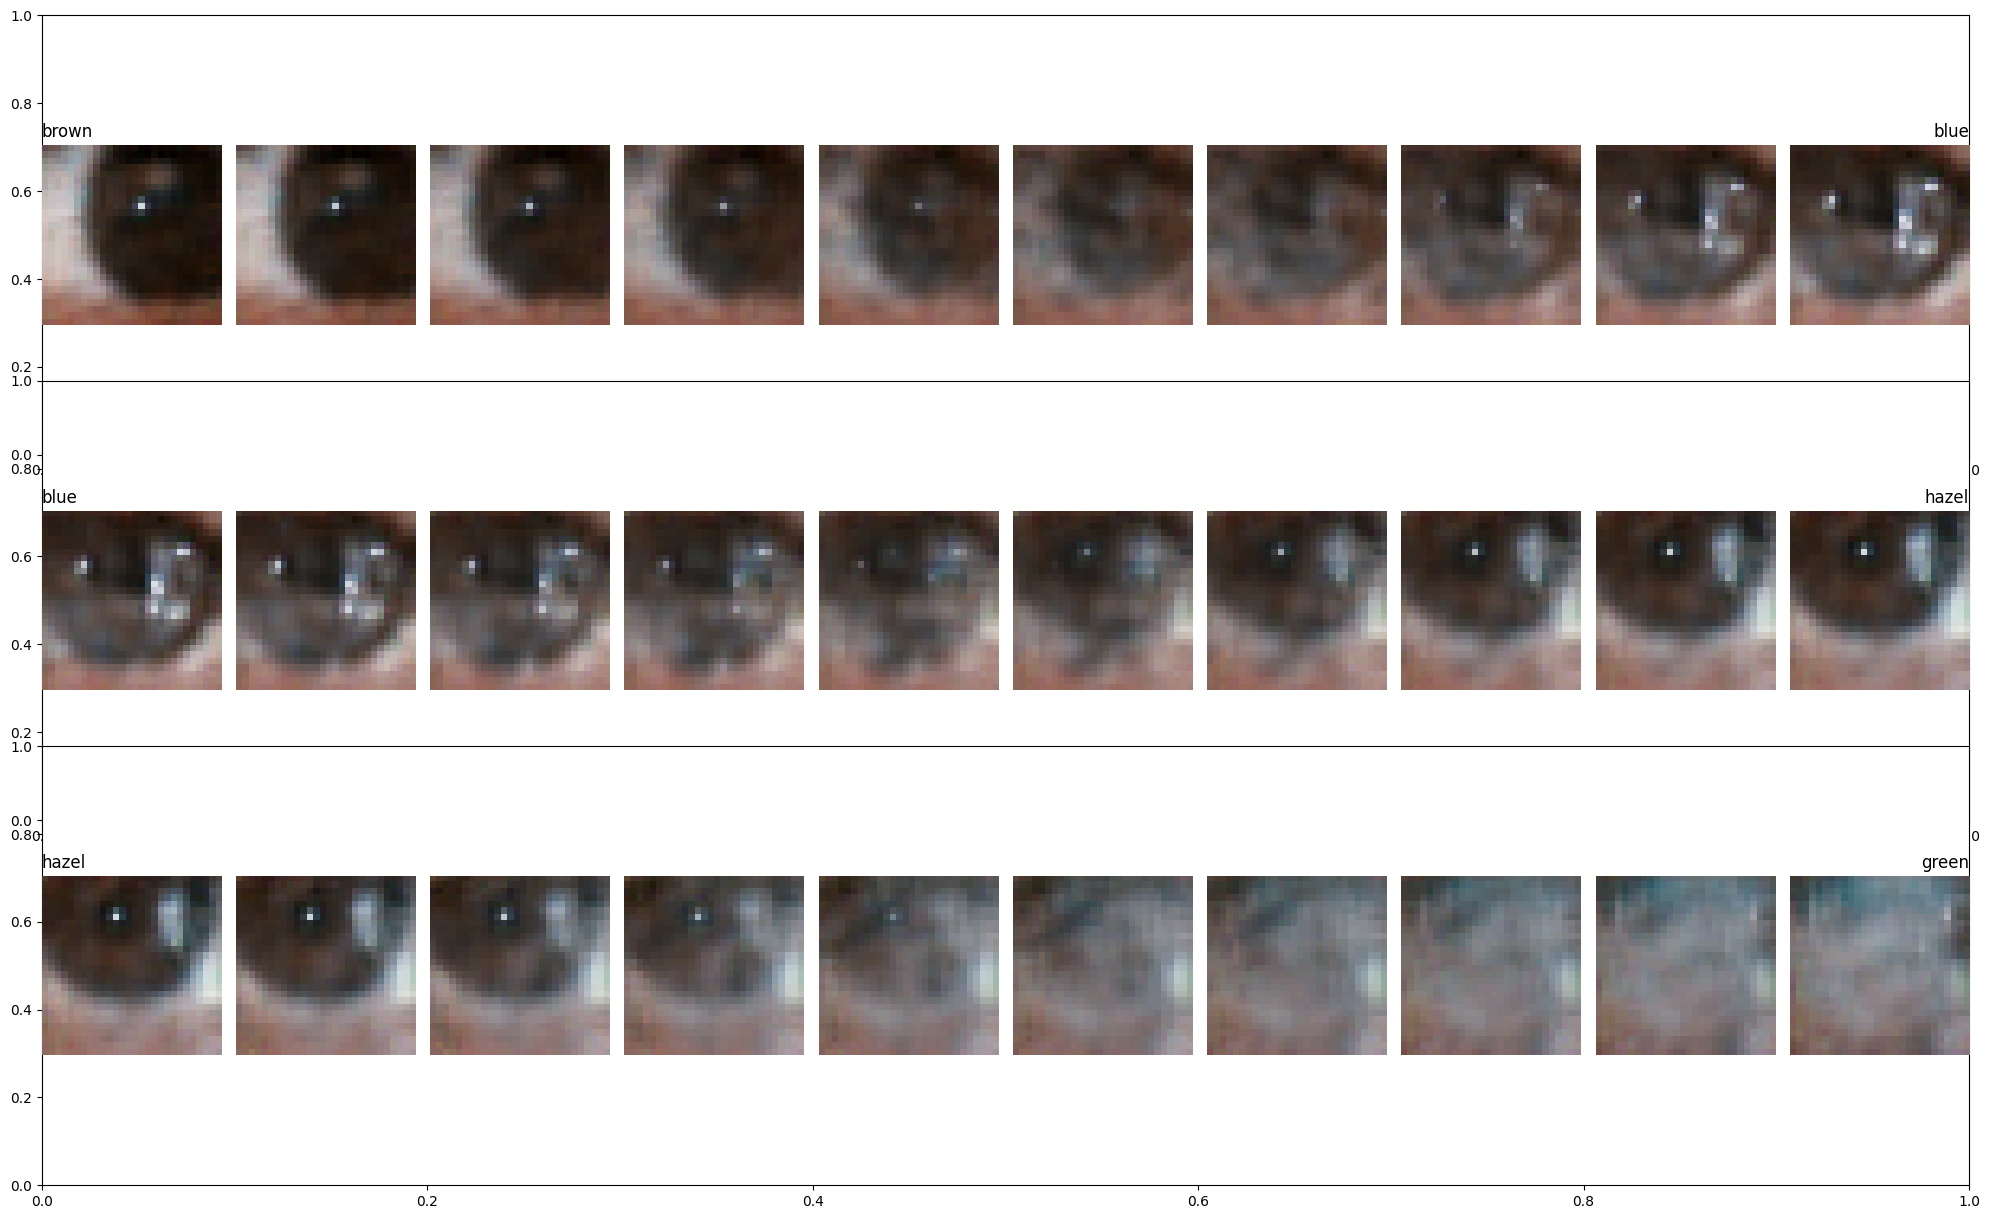


Finding best representative images for each color class...

Experimenting with hue...


In [19]:
if __name__ == "__main__":
    # Load the labels
    labels_df = pd.read_csv('/content/drive/MyDrive/ML final project/datasets/filtered_labels.csv')

    print("Reconstructing sample images...")
    reconstruct_images(latent_vectors)

    print("\nInterpolating between different eye colors...")
    #interpolate_color_sequence(decoder, latent_vectors, labels_df)
    randomer_interpolater(decoder, latent_vectors, labels_df)
    print("\nFinding best representative images for each color class...")
    find_best_representative_images(image_data, labels_df)

    print("\nExperimenting with hue...")
    #interpolate_and_apply_color_from_classes(find_best_representative_images(image_data, labels_df), image_data, labels_df)


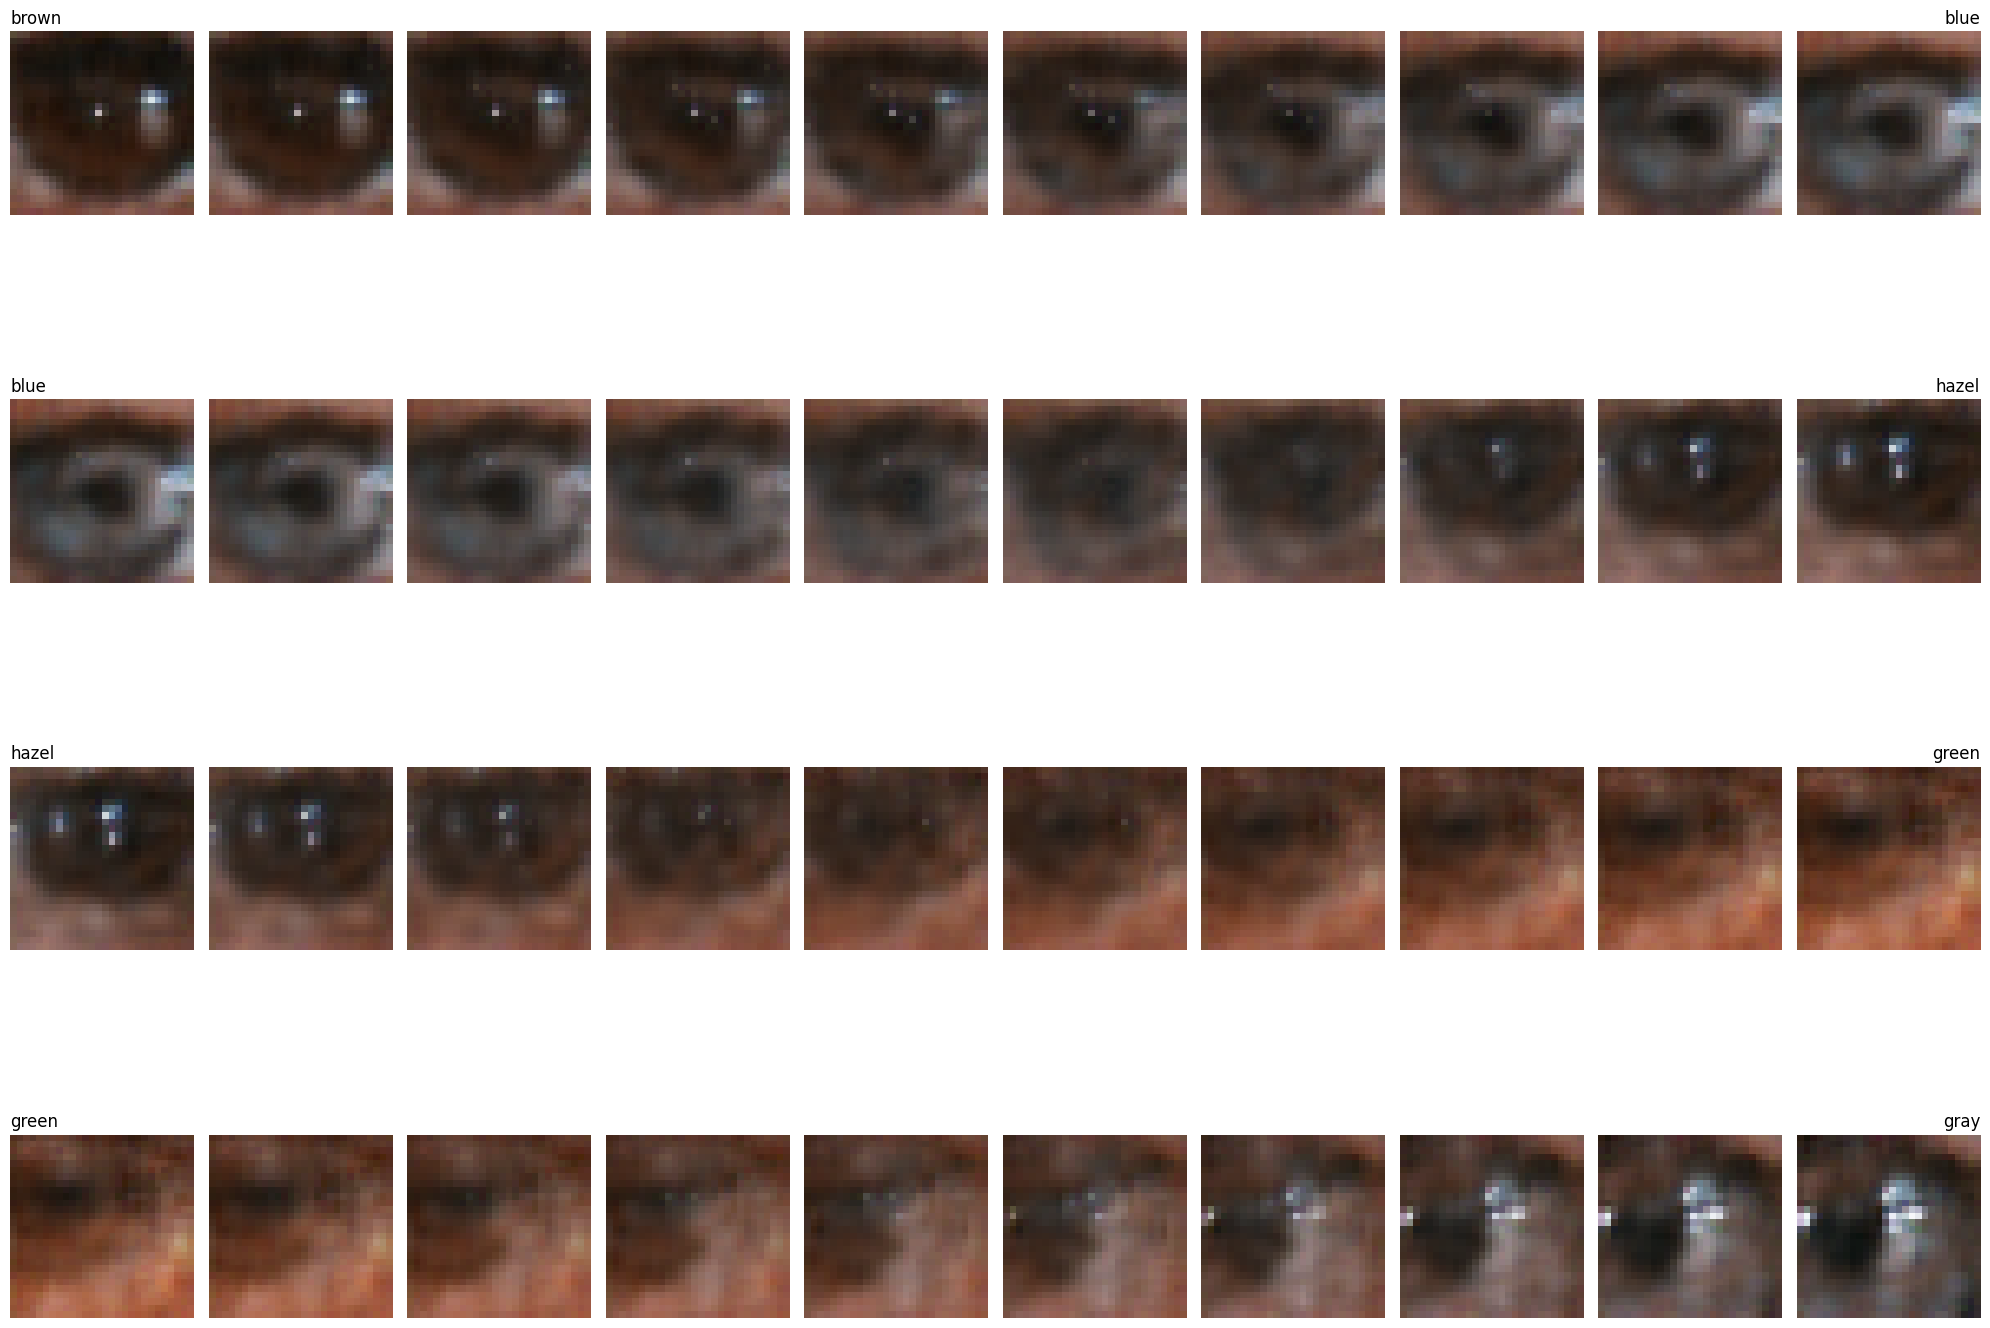

Below is testing for adding the hue of one eye to the image of another. The code was generated using Claude 3.5 Sonnet

In [20]:


def detect_iris_boundaries_from_ref(image):
    #Detect iris and pupil boundaries using Hough circles
    # Convert image to grayscale and uint8
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detect pupil (inner circle) first as it's more reliable
    pupil_circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,  # Lower threshold for edge detection
        param2=30,  # Lower threshold for circle detection
        minRadius=1,
        maxRadius=5  # Adjusted for your image size
    )

    # Detect iris (outer circle)
    iris_circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=20,
        minRadius=10,
        maxRadius=14  # Adjusted for your image size
    )

    if iris_circles is None or pupil_circles is None:
        return None, None

    # Get the most prominent circles
    iris_circle = iris_circles[0][0]
    pupil_circle = pupil_circles[0][0]

    return iris_circle, pupil_circle

# Add a debug function to visualize the circle detection
def debug_circle_detection(image, save_path=None):
    iris_circle, pupil_circle = detect_iris_boundaries(image)
    if iris_circle is None or pupil_circle is None:
        print("No circles detected!")
        return

    # Create a copy for visualization
    debug_img = image.copy()

    # Draw iris circle
    cv2.circle(debug_img,
               (int(iris_circle[0]), int(iris_circle[1])),
               int(iris_circle[2]),
               (0, 255, 0), 1)  # Green for iris

    # Draw pupil circle
    cv2.circle(debug_img,
               (int(pupil_circle[0]), int(pupil_circle[1])),
               int(pupil_circle[2]),
               (255, 0, 0), 1)  # Blue for pupil

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(debug_img)
    plt.title('Detected Circles')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path)
    plt.show()

# Add this to your main section to test the circle detection:
if __name__ == "__main__":
    # Test circle detection on first few images
    for i in range(5):
        print(f"\nTesting circle detection on image {i+1}")
        debug_circle_detection(image_data[i])




Testing circle detection on image 1


NameError: name 'detect_iris_boundaries' is not defined

In [ ]:
def detect_iris_boundaries(image):
    """Detect iris and pupil boundaries using Hough circles"""
    # Convert image to grayscale and uint8
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    enhanced = clahe.apply(gray)

    # Apply bilateral filter to reduce noise while preserving edges
    blurred = cv2.bilateralFilter(enhanced, 9, 75, 75)

    # Create a mask for the darkest regions (pupil)
    _, pupil_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)

    # Detect pupil (inner circle)
    pupil_circles = cv2.HoughCircles(
        pupil_mask,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=10,
        param1=20,  # Lower threshold for edge detection
        param2=8,   # Much lower threshold for circle detection
        minRadius=2,
        maxRadius=6
    )

    # For iris detection, use edge detection
    edges = cv2.Canny(blurred, 30, 70)

    # Detect iris (outer circle)
    iris_circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=10,
        param1=20,
        param2=8,
        minRadius=8,
        maxRadius=13
    )

    if iris_circles is None or pupil_circles is None:
        return None, None

    # Get the most prominent circles
    iris_circle = iris_circles[0][0]
    pupil_circle = pupil_circles[0][0]

    return iris_circle, pupil_circle

def debug_circle_detection(image, save_path=None):
    """Visualize detected circles and preprocessing steps"""
    # Convert image to grayscale and uint8
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    enhanced = clahe.apply(gray)

    # Apply bilateral filter
    blurred = cv2.bilateralFilter(enhanced, 9, 75, 75)

    # Create pupil mask
    _, pupil_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)

    # Edge detection for iris
    edges = cv2.Canny(blurred, 30, 70)

    # Detect circles
    iris_circle, pupil_circle = detect_iris_boundaries(image)

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Enhanced image
    plt.subplot(1, 6, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title('Enhanced')
    plt.axis('off')

    # Blurred image
    plt.subplot(1, 6, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred')
    plt.axis('off')

    # Pupil mask
    plt.subplot(1, 6, 4)
    plt.imshow(pupil_mask, cmap='gray')
    plt.title('Pupil Mask')
    plt.axis('off')

    # Edge detection
    plt.subplot(1, 6, 5)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    plt.axis('off')

    # Final result with circles
    result_img = image.copy()
    if iris_circle is not None and pupil_circle is not None:
        # Draw iris circle
        cv2.circle(result_img,
                   (int(iris_circle[0]), int(iris_circle[1])),
                   int(iris_circle[2]),
                   (0, 1, 0), 1)  # Green for iris

        # Draw pupil circle
        cv2.circle(result_img,
                   (int(pupil_circle[0]), int(pupil_circle[1])),
                   int(pupil_circle[2]),
                   (1, 0, 0), 1)  # Blue for pupil

        plt.subplot(1, 6, 6)
        plt.imshow(result_img)
        plt.title('Detected Circles')
        plt.axis('off')
    else:
        plt.subplot(1, 6, 6)
        plt.imshow(image)
        plt.title('No Circles Detected')
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Add this to your main section to test:
if __name__ == "__main__":
    # Test circle detection on first few images
    for i in range(5):
        print(f"\nTesting circle detection on image {i+1}")
        debug_circle_detection(image_data[i])

In [ ]:
def detect_iris_boundaries2(image):
    """Detect iris and pupil boundaries using Hough circles"""
    # Convert image to grayscale and uint8
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    enhanced = clahe.apply(gray)

    # First phase: Pupil detection
    # Create a binary mask for the pupil (darkest region)
    _, pupil_mask = cv2.threshold(enhanced, 40, 255, cv2.THRESH_BINARY_INV)
    # Clean up the mask
    kernel = np.ones((2,2), np.uint8)
    pupil_mask = cv2.morphologyEx(pupil_mask, cv2.MORPH_CLOSE, kernel)

    # Detect pupil
    pupil_circles = cv2.HoughCircles(
        pupil_mask,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=5,
        param1=15,    # Even lower threshold
        param2=5,     # Much lower threshold
        minRadius=2,
        maxRadius=6
    )

    # Second phase: Iris detection
    # Create a mask for the iris region
    blur = cv2.GaussianBlur(enhanced, (5,5), 0)
    edges = cv2.Canny(blur, 20, 60)

    # Detect iris
    iris_circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=5,
        param1=15,
        param2=5,
        minRadius=7,
        maxRadius=13
    )

    if iris_circles is None or pupil_circles is None:
        # Try alternative parameters for iris if initial detection failed
        iris_circles = cv2.HoughCircles(
            enhanced,  # Try on enhanced image instead of edges
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=5,
            param1=15,
            param2=5,
            minRadius=7,
            maxRadius=13
        )

        if iris_circles is None or pupil_circles is None:
            return None, None

    # Get the most prominent circles
    iris_circle = iris_circles[0][0]
    pupil_circle = pupil_circles[0][0]

    # Validate circles
    # Ensure pupil is inside iris
    pupil_x, pupil_y = pupil_circle[0], pupil_circle[1]
    iris_x, iris_y = iris_circle[0], iris_circle[1]
    distance = np.sqrt((pupil_x - iris_x)**2 + (pupil_y - iris_y)**2)

    if distance > iris_circle[2] - pupil_circle[2]:
        return None, None

    return iris_circle, pupil_circle

def debug_circle_detection(image, save_path=None):
    """Visualize detected circles and preprocessing steps"""
    # Previous preprocessing steps remain the same...
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    enhanced = clahe.apply(gray)
    _, pupil_mask = cv2.threshold(enhanced, 40, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((2,2), np.uint8)
    pupil_mask = cv2.morphologyEx(pupil_mask, cv2.MORPH_CLOSE, kernel)
    blur = cv2.GaussianBlur(enhanced, (5,5), 0)
    edges = cv2.Canny(blur, 20, 60)

    # Detect circles
    iris_circle, pupil_circle = detect_iris_boundaries2(image)

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Enhanced image
    plt.subplot(1, 6, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title('Enhanced')
    plt.axis('off')

    # Pupil mask
    plt.subplot(1, 6, 3)
    plt.imshow(pupil_mask, cmap='gray')
    plt.title('Pupil Mask')
    plt.axis('off')

    # Edge detection
    plt.subplot(1, 6, 4)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    plt.axis('off')

    # Final result with circles
    result_img = image.copy()
    if iris_circle is not None and pupil_circle is not None:
        # Draw iris circle
        cv2.circle(result_img,
                   (int(iris_circle[0]), int(iris_circle[1])),
                   int(iris_circle[2]),
                   (0, 1, 0), 1)  # Green for iris

        # Draw pupil circle
        cv2.circle(result_img,
                   (int(pupil_circle[0]), int(pupil_circle[1])),
                   int(pupil_circle[2]),
                   (0, 0, 1), 1)  # Blue for pupil

        plt.subplot(1, 6, 5)
        plt.imshow(result_img)
        plt.title('Detected Circles')
        plt.axis('off')
    else:
        plt.subplot(1, 6, 5)
        plt.imshow(image)
        plt.title('No Circles Detected')
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

if __name__ == "__main__":
    # Test circle detection on first few images
    for i in range(5):
        print(f"\nTesting circle detection on image {i+1}")
        debug_circle_detection(image_data[i])

In [ ]:
def detect_iris_boundaries(image):
    """Detect iris and pupil boundaries using Hough circles"""
    # Convert image to grayscale and uint8
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    enhanced = clahe.apply(gray)

    # First phase: Pupil detection
    # Create a binary mask for the pupil (darkest region)
    _, pupil_mask = cv2.threshold(enhanced, 40, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((1,1), np.uint8)
    pupil_mask = cv2.morphologyEx(pupil_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in pupil mask
    contours, _ = cv2.findContours(pupil_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, None

    # Find the largest contour (should be the pupil)
    pupil_contour = max(contours, key=cv2.contourArea)

    # Fit circle to pupil contour
    (pupil_x, pupil_y), pupil_radius = cv2.minEnclosingCircle(pupil_contour)

    # Second phase: Iris detection
    # Create a larger circle around the pupil for the iris
    iris_radius = pupil_radius * 3.0  # Typical iris radius is about 2.5 times pupil radius
    iris_x, iris_y = pupil_x, pupil_y

    # Validate circles
    if (pupil_radius < 2 or pupil_radius > 6 or
        iris_radius < 7 or iris_radius > 13):
        return None, None

    return ([iris_x, iris_y, iris_radius], [pupil_x, pupil_y, pupil_radius])

def unwrap_iris(image, iris_circle, pupil_circle):
    """Unwrap iris region to rectangular form"""
    center_x, center_y = int(iris_circle[0]), int(iris_circle[1])
    iris_radius = int(iris_circle[2])
    pupil_radius = int(pupil_circle[2])

    # Create unwrapped image
    unwrapped_height = int(iris_radius - pupil_radius)
    unwrapped_width = 360  # One degree per pixel
    unwrapped = np.zeros((unwrapped_height, unwrapped_width, 3))

    # Create coordinate maps for vectorized operation
    theta = np.linspace(0, 2*np.pi, unwrapped_width)
    r = np.linspace(pupil_radius, iris_radius, unwrapped_height)
    theta_grid, r_grid = np.meshgrid(theta, r)

    # Calculate x and y coordinates
    x_grid = center_x + r_grid * np.cos(theta_grid)
    y_grid = center_y + r_grid * np.sin(theta_grid)

    # Round coordinates and ensure they're within bounds
    x_grid = np.clip(np.round(x_grid), 0, image.shape[1]-1).astype(int)
    y_grid = np.clip(np.round(y_grid), 0, image.shape[0]-1).astype(int)

    # Map pixels
    for c in range(3):  # For each color channel
        unwrapped[:, :, c] = image[:, :, c][y_grid, x_grid]

    return unwrapped

def debug_unwrap(image, save_path=None):
    """Debug visualization for iris unwrapping process"""
    # Detect circles
    iris_circle, pupil_circle = detect_iris_boundaries(image)

    plt.figure(figsize=(15, 3))

    # Original image with circles
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    if iris_circle is not None and pupil_circle is not None:
        # Draw circles on copy of original
        marked = image.copy()
        cv2.circle(marked,
                  (int(iris_circle[0]), int(iris_circle[1])),
                  int(iris_circle[2]),
                  (0, 1, 0), 1)
        cv2.circle(marked,
                  (int(pupil_circle[0]), int(pupil_circle[1])),
                  int(pupil_circle[2]),
                  (1, 0, 0), 1)

        plt.subplot(1, 4, 2)
        plt.imshow(marked)
        plt.title('Detected Circles')
        plt.axis('off')

        # Unwrap iris
        unwrapped = unwrap_iris(image, iris_circle, pupil_circle)
        plt.subplot(1, 4, 3)
        plt.imshow(unwrapped)
        plt.title('Unwrapped Iris')
        plt.axis('off')

        # Resize for encoder
        resized = cv2.resize(unwrapped, (28, 28))
        plt.subplot(1, 4, 4)
        plt.imshow(resized)
        plt.title('Resized')
        plt.axis('off')
    else:
        plt.subplot(1, 4, 2)
        plt.text(0.5, 0.5, 'No circles detected', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

    return iris_circle is not None and pupil_circle is not None

# Add to main section:
if __name__ == "__main__":

    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye2.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye2.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nTesting iris unwrapping...")
    #for i in range(5):
    for color, image in reference_images.items():
        #print(f"\nProcessing image {image}")
        success = debug_unwrap(image)
        if not success:
            print("Failed to detect circles")

In [ ]:
def unwrap_iris(image, iris_circle, pupil_circle):
    """Unwrap iris region to rectangular form"""
    center_x, center_y = int(iris_circle[0]), int(iris_circle[1])
    iris_radius = int(iris_circle[2])
    pupil_radius = int(pupil_circle[2])

    # Create unwrapped image
    unwrapped_height = iris_radius - pupil_radius
    unwrapped_width = 360  # One degree per pixel
    unwrapped = np.zeros((unwrapped_height, unwrapped_width, 3))

    for r in range(unwrapped_height):
        for theta in range(unwrapped_width):
            radius = pupil_radius + r
            angle = np.deg2rad(theta)
            x = int(center_x + radius * np.cos(angle))
            y = int(center_y + radius * np.sin(angle))

            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                unwrapped[r, theta] = image[y, x]

    return unwrapped

In [ ]:
def extract_iris_colors(image_data, encoder):
    """Extract iris colors from images and encode them"""
    color_vectors = {}

    for i, img in enumerate(image_data):
        # Detect iris boundaries
        iris_circle, pupil_circle = detect_iris_boundaries(img)
        if iris_circle is None or pupil_circle is None:
            continue

        # Unwrap iris
        unwrapped_iris = unwrap_iris(img, iris_circle, pupil_circle)

        # Resize unwrapped iris to match encoder input size
        resized_iris = cv2.resize(unwrapped_iris, (28, 28))

        # Get latent vector
        latent_vector = encoder.predict(np.expand_dims(resized_iris, 0))[0]

        # Store vector based on color class
        color = labels_df.iloc[i]['label']
        if color not in color_vectors:
            color_vectors[color] = []
        color_vectors[color].append(latent_vector)

    # Average vectors for each color
    averaged_vectors = {
        color: np.mean(vectors, axis=0)
        for color, vectors in color_vectors.items()
    }

    return averaged_vectors


In [ ]:
def apply_iris_color(target_image, desired_color, color_vectors, decoder, intensity=1.0):
    """Apply specified iris color to target image"""
    # Detect iris in target image
    iris_circle, pupil_circle = detect_iris_boundaries(target_image)
    if iris_circle is None or pupil_circle is None:
        return target_image

    # Get color vector
    if desired_color not in color_vectors:
        raise ValueError(f"Color {desired_color} not found in dataset")
    color_vector = color_vectors[desired_color]

    # Generate colored iris using decoder
    colored_iris = decoder.predict(np.expand_dims(color_vector, 0))[0]

    # Create mask for iris region
    mask = np.zeros_like(target_image)
    cv2.circle(mask, (int(iris_circle[0]), int(iris_circle[1])),
              int(iris_circle[2]), (1, 1, 1), -1)
    cv2.circle(mask, (int(pupil_circle[0]), int(pupil_circle[1])),
              int(pupil_circle[2]), (0, 0, 0), -1)

    # Blend original and colored image
    result = target_image.copy()
    colored_resized = cv2.resize(colored_iris, (target_image.shape[1], target_image.shape[0]))
    result = (1 - intensity) * result + intensity * (colored_resized * mask + result * (1 - mask))

    return result

In [ ]:
def apply_iris_color(target_image, desired_color, color_vectors, decoder, intensity=0.7):
    """Apply specified iris color to target image with visualization"""
    # Create figure for visualization
    plt.figure(figsize=(20, 4))
    current_plot = 1

    # Show original image
    plt.subplot(1, 5, current_plot)
    plt.imshow(target_image)
    plt.title('Original')
    plt.axis('off')
    current_plot += 1

    # Detect iris boundaries
    iris_circle, pupil_circle = detect_iris_boundaries(target_image)
    if iris_circle is None or pupil_circle is None:
        print("No circles detected!")
        return target_image

    # Create visualization of detected circles
    circles_img = target_image.copy()
    cv2.circle(circles_img,
               (int(iris_circle[0]), int(iris_circle[1])),
               int(iris_circle[2]),
               (0, 1, 0), 1)  # Green for iris
    cv2.circle(circles_img,
               (int(pupil_circle[0]), int(pupil_circle[1])),
               int(pupil_circle[2]),
               (1, 0, 0), 1)  # Blue for pupil

    plt.subplot(1, 5, current_plot)
    plt.imshow(circles_img)
    plt.title('Detected Circles')
    plt.axis('off')
    current_plot += 1

    # Get color vector and generate colored iris
    if desired_color not in color_vectors:
        raise ValueError(f"Color {desired_color} not found in dataset")
    color_vector = color_vectors[desired_color]
    colored_iris = decoder.predict(np.expand_dims(color_vector, 0))[0]

    # Show generated color pattern
    plt.subplot(1, 5, current_plot)
    plt.imshow(colored_iris)
    plt.title('Generated Color Pattern')
    plt.axis('off')
    current_plot += 1

    # Create masks for iris and pupil regions
    mask = np.zeros_like(target_image)
    cv2.circle(mask,
              (int(iris_circle[0]), int(iris_circle[1])),
              int(iris_circle[2]),
              (1, 1, 1), -1)
    cv2.circle(mask,
              (int(pupil_circle[0]), int(pupil_circle[1])),
              int(pupil_circle[2]),
              (0, 0, 0), -1)

    # Show mask
    plt.subplot(1, 5, current_plot)
    plt.imshow(mask)
    plt.title('Blend Mask')
    plt.axis('off')
    current_plot += 1

    # Blend images
    result = target_image.copy()
    colored_resized = cv2.resize(colored_iris, (target_image.shape[1], target_image.shape[0]))

    # Modify blending to preserve more of the original texture
    # Convert to HSV for better color blending
    original_hsv = cv2.cvtColor((target_image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    colored_hsv = cv2.cvtColor((colored_resized * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

    # Only blend the hue and saturation channels
    result_hsv = original_hsv.copy()
    result_hsv[..., 0] = cv2.addWeighted(original_hsv[..., 0], 1 - intensity,
                                        colored_hsv[..., 0], intensity, 0)
    result_hsv[..., 1] = cv2.addWeighted(original_hsv[..., 1], 1 - intensity,
                                        colored_hsv[..., 1], intensity, 0)

    # Convert back to RGB
    result = cv2.cvtColor(result_hsv, cv2.COLOR_HSV2RGB) / 255.0

    # Apply mask
    result = result * mask + target_image * (1 - mask)

    # Show final result
    plt.subplot(1, 5, current_plot)
    plt.imshow(result)
    plt.title('Final Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return result

# Add visualization for extract_iris_colors function
def extract_iris_colors(image_data, encoder, labels_df, debug=False):
    """Extract iris colors from images and encode them with visualization"""
    color_vectors = {}

    for i, img in enumerate(image_data):
        if debug and i < 5:  # Show process for first 5 images
            plt.figure(figsize=(15, 3))
            plt.subplot(1, 4, 1)
            plt.imshow(img)
            plt.title('Original')
            plt.axis('off')

        # Detect iris boundaries
        iris_circle, pupil_circle = detect_iris_boundaries(img)
        if iris_circle is None or pupil_circle is None:
            continue

        # Unwrap iris
        unwrapped_iris = unwrap_iris(img, iris_circle, pupil_circle)

        if debug and i < 5:
            plt.subplot(1, 4, 2)
            plt.imshow(unwrapped_iris)
            plt.title('Unwrapped Iris')
            plt.axis('off')

        # Resize unwrapped iris
        resized_iris = cv2.resize(unwrapped_iris, (28, 28))

        if debug and i < 5:
            plt.subplot(1, 4, 3)
            plt.imshow(resized_iris)
            plt.title('Resized')
            plt.axis('off')

        # Get latent vector
        latent_vector = encoder.predict(np.expand_dims(resized_iris, 0))[0]

        # Store vector based on color class
        color = labels_df.iloc[i]['label']
        if color not in color_vectors:
            color_vectors[color] = []
        color_vectors[color].append(latent_vector)

        if debug and i < 5:
            # Visualize reconstruction from latent vector
            reconstructed = decoder.predict(np.expand_dims(latent_vector, 0))[0]
            plt.subplot(1, 4, 4)
            plt.imshow(reconstructed)
            plt.title('Reconstructed')
            plt.axis('off')
            plt.show()

    # Average vectors for each color
    averaged_vectors = {
        color: np.mean(vectors, axis=0)
        for color, vectors in color_vectors.items()
    }

    return averaged_vectors

# In your main section:
"""
if __name__ == "__main__":
    print("\nExtracting iris colors with visualization...")
    color_vectors = extract_iris_colors(image_data, encoder, labels_df, debug=True)

    print("\nTesting color application with visualization...")
    sample_image = image_data[0]
    for color in ['blue', 'green', 'brown', 'hazel']:
        print(f"\nApplying {color} color...")
        colored_image = apply_iris_color(sample_image, color, color_vectors, decoder, intensity=0.7)
"""

In [ ]:
if __name__ == "__main__":
    # ... existing code ...

    print("\nExtracting iris colors...")
    #color_vectors = extract_iris_colors(image_data, encoder)

    color_vectors = extract_iris_colors(image_data, encoder, labels_df, debug=True)

    print("\nTesting color application...")
    # Test on a sample image
    sample_image = image_data[0]
    #colored_image = apply_iris_color(sample_image, 'blue', color_vectors, decoder, intensity=0.7)

    for color in ['blue', 'green', 'brown', 'hazel']:
      print(f"\nApplying {color} color...")
      colored_image = apply_iris_color(sample_image, color, color_vectors, decoder, intensity=0.7)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colored_image)
    plt.title('Color Applied')
    plt.axis('off')
    plt.show()

In [ ]:
def detect_iris_boundaries_simple(image):
    """Simplified circle detection for preprocessed reference images"""
    # Convert image to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        gray = (image * 255).astype(np.uint8)

    # Find center of the image
    center_x = image.shape[1] // 2
    center_y = image.shape[0] // 2

    # Create binary masks for pupil and iris
    _, pupil_mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)
    _, iris_mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

    # Find pupil radius
    pupil_points = np.where(pupil_mask > 0)
    if len(pupil_points[0]) == 0:
        return None, None

    pupil_radius = np.mean(np.sqrt(
        (pupil_points[1] - center_x)**2 +
        (pupil_points[0] - center_y)**2
    )) * 0.7  # Adjust factor as needed

    # Find iris radius
    iris_points = np.where(iris_mask > 0)
    if len(iris_points[0]) == 0:
        return None, None

    iris_radius = np.mean(np.sqrt(
        (iris_points[1] - center_x)**2 +
        (iris_points[0] - center_y)**2
    )) * 0.9  # Adjust factor as needed

    # Create circle parameters
    iris_circle = [center_x, center_y, iris_radius]
    pupil_circle = [center_x, center_y, pupil_radius]

    return iris_circle, pupil_circle

In [ ]:
def load_reference_images(reference_paths):
    """Load and preprocess reference eye images"""
    reference_images = {}
    for color, path in reference_paths.items():
        # Load image
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to match our model's input size
        img = cv2.resize(img, (28, 28))

        # Normalize
        img = img.astype(np.float32) / 255.0

        reference_images[color] = img

    return reference_images

def extract_iris_color_from_reference(image, encoder, decoder, debug=True):
    """Extract iris color from a single reference image with improved preprocessing"""
    # Ensure image is properly normalized to [-1, 1] for tanh activation
    if image.max() > 1.0:
        image = image.astype(np.float32) / 255.0
    image = image * 2.0 - 1.0  # Scale to [-1, 1]

    # Detect iris and pupil
    iris_circle, pupil_circle = detect_iris_boundaries_simple(image)

    if iris_circle is None or pupil_circle is None:
        raise ValueError("Could not detect valid iris boundaries")

    # Create visualization
    if debug:
        plt.figure(figsize=(20, 4))

        # Original image
        plt.subplot(1, 5, 1)
        plt.imshow((image + 1.0) / 2.0)  # Convert back to [0, 1] for display
        plt.title('Reference Image')
        plt.axis('off')

        # Detected circles
        marked = image.copy()
        cv2.circle(marked,
                  (int(iris_circle[0]), int(iris_circle[1])),
                  int(iris_circle[2]),
                  (0, 1, 0), 1)
        cv2.circle(marked,
                  (int(pupil_circle[0]), int(pupil_circle[1])),
                  int(pupil_circle[2]),
                  (1, 0, 0), 1)
        plt.subplot(1, 5, 2)
        plt.imshow((marked + 1.0) / 2.0)
        plt.title('Detected Circles')
        plt.axis('off')

    # Create and apply mask
    mask = np.zeros_like(image)
    cv2.circle(mask,
              (int(iris_circle[0]), int(iris_circle[1])),
              int(iris_circle[2]),
              (1, 1, 1), -1)
    cv2.circle(mask,
              (int(pupil_circle[0]), int(pupil_circle[1])),
              int(pupil_circle[2]),
              (0, 0, 0), -1)

    masked_image = image * mask

    if debug:
        plt.subplot(1, 5, 3)
        plt.imshow((masked_image + 1.0) / 2.0)
        plt.title('Masked Iris')
        plt.axis('off')

    # Get latent vector
    latent_vector = encoder.predict(np.expand_dims(masked_image, 0))[0]

    # Test reconstruction
    if debug:
        # Reconstruct from latent vector
        reconstructed = decoder.predict(np.expand_dims(latent_vector, 0))[0]

        # Show both intermediate and final reconstruction
        plt.subplot(1, 5, 4)
        plt.imshow((reconstructed + 1.0) / 2.0)
        plt.title('Direct Reconstruction')
        plt.axis('off')

        # Apply mask to reconstruction
        masked_reconstruction = reconstructed * mask
        plt.subplot(1, 5, 5)
        plt.imshow((masked_reconstruction + 1.0) / 2.0)
        plt.title('Masked Reconstruction')
        plt.axis('off')

        plt.show()

    return latent_vector

def create_color_vectors_from_references(reference_images, encoder):
    """Create color vectors from reference images"""
    color_vectors = {}

    for color, image in reference_images.items():
        print(f"\nProcessing {color} reference image...")
        try:
            color_vectors[color] = extract_iris_color_from_reference(image, encoder, decoder)
        except ValueError as e:
            print(f"Error processing {color} image: {e}")

    return color_vectors

def apply_iris_color(target_image, desired_color, color_vectors, decoder, intensity=0.7):
    """Apply specified iris color to target image with improved blending"""
    # Normalize target image to [-1, 1]
    if target_image.max() > 1.0:
        target_image = target_image.astype(np.float32) / 255.0
    target_image = target_image * 2.0 - 1.0

    # Detect iris boundaries
    iris_circle, pupil_circle = detect_iris_boundaries_simple(target_image)
    if iris_circle is None or pupil_circle is None:
        print("No circles detected in target image!")
        return (target_image + 1.0) / 2.0  # Return normalized image

    # Create mask
    mask = np.zeros_like(target_image)
    cv2.circle(mask,
              (int(iris_circle[0]), int(iris_circle[1])),
              int(iris_circle[2]),
              (1, 1, 1), -1)
    cv2.circle(mask,
              (int(pupil_circle[0]), int(pupil_circle[1])),
              int(pupil_circle[2]),
              (0, 0, 0), -1)

    # Generate colored iris
    color_vector = color_vectors[desired_color]
    colored_iris = decoder.predict(np.expand_dims(color_vector, 0))[0]

    # Resize colored iris if needed
    if colored_iris.shape != target_image.shape:
        colored_iris = cv2.resize(colored_iris,
                                (target_image.shape[1], target_image.shape[0]))

    # Blend images in LAB color space for better color preservation
    target_lab = cv2.cvtColor(((target_image + 1.0) / 2.0 * 255).astype(np.uint8),
                             cv2.COLOR_RGB2LAB)
    colored_lab = cv2.cvtColor(((colored_iris + 1.0) / 2.0 * 255).astype(np.uint8),
                              cv2.COLOR_RGB2LAB)

    # Only blend A and B channels
    result_lab = target_lab.copy()
    result_lab[..., 1:] = cv2.addWeighted(target_lab[..., 1:], 1 - intensity,
                                         colored_lab[..., 1:], intensity, 0)

    # Convert back to RGB
    result = cv2.cvtColor(result_lab, cv2.COLOR_LAB2RGB).astype(np.float32) / 255.0

    # Apply mask
    result = result * mask + ((target_image + 1.0) / 2.0) * (1 - mask)

    return result

# Example usage in main:
if __name__ == "__main__":
    # Define paths to reference images
    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nExtracting color vectors from reference images...")
    color_vectors = create_color_vectors_from_references(reference_images, encoder)

    print("\nTesting color application...")
    # Test on a sample image from your dataset
    sample_image = image_data[0]
    for color in color_vectors.keys():
        print(f"\nApplying {color} color...")
        colored_image = apply_iris_color(sample_image, color, color_vectors, decoder, intensity=0.7)

In [ ]:
def load_reference_images(reference_paths):
    """Load and preprocess reference eye images"""
    reference_images = {}
    for color, path in reference_paths.items():
        # Load image
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to match our model's input size
        img = cv2.resize(img, (28, 28))

        # Normalize
        img = img.astype(np.float32) / 255.0

        reference_images[color] = img

    return reference_images

In [ ]:
def extract_iris_color_from_reference(image, encoder, decoder, debug=True):
    """Extract iris color from a single reference image"""
    # Ensure image is properly normalized to [-1, 1]
    if image.max() > 1.0:
        image = image.astype(np.float32) / 255.0
    image = image * 2.0 - 1.0

    # Detect iris and pupil with is_reference=True
    iris_circle, pupil_circle = detect_iris_boundaries_simple(image)

    if debug:
        plt.figure(figsize=(20, 4))
        plt.subplot(1, 5, 1)
        plt.imshow((image + 1.0) / 2.0)
        plt.title('Reference Image')
        plt.axis('off')

        # Show detected circles
        marked = image.copy()
        cv2.circle(marked,
                  (int(iris_circle[0]), int(iris_circle[1])),
                  int(iris_circle[2]),
                  (0, 1, 0), 1)
        cv2.circle(marked,
                  (int(pupil_circle[0]), int(pupil_circle[1])),
                  int(pupil_circle[2]),
                  (1, 0, 0), 1)
        plt.subplot(1, 5, 2)
        plt.imshow((marked + 1.0) / 2.0)
        plt.title('Detected Circles')
        plt.axis('off')

    # Create mask
    mask = np.zeros_like(image)
    cv2.circle(mask,
              (int(iris_circle[0]), int(iris_circle[1])),
              int(iris_circle[2]),
              (1, 1, 1), -1)
    cv2.circle(mask,
              (int(pupil_circle[0]), int(pupil_circle[1])),
              int(pupil_circle[2]),
              (0, 0, 0), -1)

    masked_image = image * mask

    if debug:
        plt.subplot(1, 5, 3)
        plt.imshow((masked_image + 1.0) / 2.0)
        plt.title('Masked Iris')
        plt.axis('off')

    # Get latent vector
    latent_vector = encoder.predict(np.expand_dims(masked_image, 0))[0]

    if debug:
        reconstructed = decoder.predict(np.expand_dims(latent_vector, 0))[0]
        plt.subplot(1, 5, 4)
        plt.imshow((reconstructed + 1.0) / 2.0)
        plt.title('Reconstructed')
        plt.axis('off')
        plt.show()

    return latent_vector

def create_color_vectors_from_references(reference_images, encoder, decoder):
    """Create color vectors from reference images"""
    color_vectors = {}

    for color, image in reference_images.items():
        print(f"\nProcessing {color} reference image...")
        try:
            color_vectors[color] = extract_iris_color_from_reference(
                image, encoder, decoder, debug=True
            )
            print(f"Successfully processed {color} image")
        except Exception as e:
            print(f"Error processing {color} image: {e}")

    return color_vectors

def load_reference_images(reference_paths):
    """Load and preprocess reference eye images"""
    reference_images = {}
    for color, path in reference_paths.items():
        # Load image
        img = cv2.imread(path)
        if img is None:
            print(f"Failed to load image at path: {path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to match our model's input size
        img = cv2.resize(img, (28, 28))

        # Normalize
        img = img.astype(np.float32) / 255.0

        reference_images[color] = img

    return reference_images

# In your main section:
if __name__ == "__main__":
    # Define paths to reference images
    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nExtracting color vectors from reference images...")
    color_vectors = create_color_vectors_from_references(reference_images, encoder, decoder)

In [ ]:
def detect_iris_boundaries(image):
    """Detect iris and pupil boundaries using Hough circles"""
    # Convert image to grayscale and uint8
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    enhanced = clahe.apply(gray)

    # First phase: Pupil detection
    # Create a binary mask for the pupil (darkest region)
    _, pupil_mask = cv2.threshold(enhanced, 40, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((1,1), np.uint8)
    pupil_mask = cv2.morphologyEx(pupil_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in pupil mask
    contours, _ = cv2.findContours(pupil_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, None

    # Find the largest contour (should be the pupil)
    pupil_contour = max(contours, key=cv2.contourArea)

    # Fit circle to pupil contour
    (pupil_x, pupil_y), pupil_radius = cv2.minEnclosingCircle(pupil_contour)

    # Second phase: Iris detection
    # Create a larger circle around the pupil for the iris
    iris_radius = pupil_radius * 3.0  # Typical iris radius is about 2.5 times pupil radius
    iris_x, iris_y = pupil_x, pupil_y

    # Validate circles
    if (pupil_radius < 2 or pupil_radius > 6 or
        iris_radius < 7 or iris_radius > 13):
        return None, None

    return ([iris_x, iris_y, iris_radius], [pupil_x, pupil_y, pupil_radius])

def unwrap_iris(image, iris_circle, pupil_circle):
    """Unwrap iris region to rectangular form"""
    center_x, center_y = int(iris_circle[0]), int(iris_circle[1])
    iris_radius = int(iris_circle[2])
    pupil_radius = int(pupil_circle[2])

    # Create unwrapped image
    unwrapped_height = int(iris_radius - pupil_radius)
    unwrapped_width = 360  # One degree per pixel
    unwrapped = np.zeros((unwrapped_height, unwrapped_width, 3))

    # Create coordinate maps for vectorized operation
    theta = np.linspace(0, 2*np.pi, unwrapped_width)
    r = np.linspace(pupil_radius, iris_radius, unwrapped_height)
    theta_grid, r_grid = np.meshgrid(theta, r)

    # Calculate x and y coordinates
    x_grid = center_x + r_grid * np.cos(theta_grid)
    y_grid = center_y + r_grid * np.sin(theta_grid)
6
    # Round coordinates and ensure they're within bounds
    x_grid = np.clip(np.round(x_grid), 0, image.shape[1]-1).astype(int)
    y_grid = np.clip(np.round(y_grid), 0, image.shape[0]-1).astype(int)

    # Map pixels
    for c in range(3):  # For each color channel
        unwrapped[:, :, c] = image[:, :, c][y_grid, x_grid]

    return unwrapped

def debug_unwrap(image, save_path=None):
    """Debug visualization for iris unwrapping process"""
    # Detect circles
    iris_circle, pupil_circle = detect_iris_boundaries(image)

    plt.figure(figsize=(15, 3))

    # Original image with circles
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    if iris_circle is not None and pupil_circle is not None:
        # Draw circles on copy of original
        marked = image.copy()
        cv2.circle(marked,
                  (int(iris_circle[0]), int(iris_circle[1])),
                  int(iris_circle[2]),
                  (0, 1, 0), 1)
        cv2.circle(marked,
                  (int(pupil_circle[0]), int(pupil_circle[1])),
                  int(pupil_circle[2]),
                  (1, 0, 0), 1)

        plt.subplot(1, 4, 2)
        plt.imshow(marked)
        plt.title('Detected Circles')
        plt.axis('off')

        # Unwrap iris
        unwrapped = unwrap_iris(image, iris_circle, pupil_circle)
        plt.subplot(1, 4, 3)
        plt.imshow(unwrapped)
        plt.title('Unwrapped Iris')
        plt.axis('off')

        # Resize for encoder
        resized = cv2.resize(unwrapped, (28, 28))
        plt.subplot(1, 4, 4)
        plt.imshow(resized)
        plt.title('Resized')
        plt.axis('off')
    else:
        plt.subplot(1, 4, 2)
        plt.text(0.5, 0.5, 'No circles detected', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

    return resized, iris_circle is not None and pupil_circle is not None

# Add to main section:
if __name__ == "__main__":

    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye2.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye2.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nTesting iris unwrapping...")
    #for i in range(5):
    for color, image in reference_images.items():
        #print(f"\nProcessing image {image}")
        _, success = debug_unwrap(image)
        if not success:
            print("Failed to detect circles")

In [ ]:
def extract_iris_colors(reference_images, encoder):
    """Extract iris colors from reference images and encode them"""
    color_vectors = {}

    for color, image in reference_images.items():
        print(f"\nProcessing {color} reference image...")
        try:
            # normalize image
            if image.max() > 1.0:
              image = image.astype(np.float32) / 255.0

            # Detect iris boundaries
            iris_circle, pupil_circle = detect_iris_boundaries(image)
            if iris_circle is None or pupil_circle is None:
                raise ValueError("Could not detect iris boundaries")

            # Unwrap iris
            unwrapped = unwrap_iris(image, iris_circle, pupil_circle)

            # Resize for encoder
            resized = cv2.resize(unwrapped, (28, 28))
            resized = np.clip(resized,0,1)

            # Get latent vector
            latent_vector = encoder.predict(np.expand_dims(resized, 0))[0]

            # Store the vector
            color_vectors[color] = latent_vector

            # Debug visualization
            debug_unwrap(image)

            # debugging reconstructions
            reconstructed = decoder.predict(np.expand_dims(latent_vector, 0))[0]
            plt.figure(figsize=(10, 2))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title('Original')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(resized)
            plt.title('Preprocessed')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(np.clip(reconstructed, 0, 1))
            plt.title('Reconstructed')
            plt.axis('off')
            plt.show()




        except Exception as e:
            print(f"Error processing {color} image: {e}")

    return resized, color_vectors

"""
    color_vectors = {}

    for i, img in enumerate(image_data):
        # Detect iris boundaries
        iris_circle, pupil_circle = detect_iris_boundaries(img)
        if iris_circle is None or pupil_circle is None:
            continue

        # Unwrap iris
        unwrapped_iris = unwrap_iris(img, iris_circle, pupil_circle)

        # Resize unwrapped iris to match encoder input size
        resized_iris = cv2.resize(unwrapped_iris, (28, 28))

        # Get latent vector
        latent_vector = encoder.predict(np.expand_dims(resized_iris, 0))[0]

        # Store vector based on color class
        color = labels_df.iloc[i]['label']
        if color not in color_vectors:
            color_vectors[color] = []
        color_vectors[color].append(latent_vector)

    # Average vectors for each color
    averaged_vectors = {
        color: np.mean(vectors, axis=0)
        for color, vectors in color_vectors.items()
    }

    return averaged_vectors
"""

In [ ]:
def apply_iris_color(colored_iris_test, target_image, desired_color, color_vectors, encoder, decoder, intensity=0.7):
    """Apply specified iris color to target image with visualization"""

    # query normalization
    if target_image.max() > 1.0:
        target_image = target_image.astype(np.float32) / 255.0

    image_embedding = encoder.predict(np.expand_dims(target_image, 0))[0]

    # Create figure for visualization
    plt.figure(figsize=(20, 4))
    current_plot = 1

    # Show original image
    plt.subplot(1, 5, current_plot)
    plt.imshow(target_image)
    plt.title('Original')
    plt.axis('off')
    current_plot += 1

    # Detect iris boundaries
    iris_circle, pupil_circle = detect_iris_boundaries2(target_image)
    if iris_circle is None or pupil_circle is None:
        print("No circles detected!")
        return target_image

    # Create visualization of detected circles
    circles_img = target_image.copy()
    cv2.circle(circles_img,
               (int(iris_circle[0]), int(iris_circle[1])),
               int(iris_circle[2]),
               (0, 1, 0), 1)  # Green for iris
    cv2.circle(circles_img,
               (int(pupil_circle[0]), int(pupil_circle[1])),
               int(pupil_circle[2]),
               (1, 0, 0), 1)  # Blue for pupil

    plt.subplot(1, 5, current_plot)
    plt.imshow(circles_img)
    plt.title('Detected Circles')
    plt.axis('off')
    current_plot += 1

    # Get color vector and generate colored iris
    if desired_color not in color_vectors:
        raise ValueError(f"Color {desired_color} not found in dataset")

    color_vector = color_vectors[desired_color]
    colored_iris = decoder.predict(np.expand_dims(color_vector, 0))[0]
    colored_iris = np.clip(colored_iris, 0, 1)

    # Show generated color pattern
    plt.subplot(1, 5, current_plot)
    plt.imshow(colored_iris_test)
    plt.title('Generated Color Pattern')
    plt.axis('off')
    current_plot += 1

    # Create masks for iris and pupil regions
    mask = np.zeros_like(target_image)
    cv2.circle(mask,
              (int(iris_circle[0]), int(iris_circle[1])),
              int(iris_circle[2]),
              (1, 1, 1), -1)
    cv2.circle(mask,
              (int(pupil_circle[0]), int(pupil_circle[1])),
              int(pupil_circle[2]),
              (0, 0, 0), -1)

    # Show mask
    plt.subplot(1, 5, current_plot)
    plt.imshow(mask)
    plt.title('Blend Mask')
    plt.axis('off')
    current_plot += 1

    # Blend images
    result = target_image.copy()
    colored_resized = cv2.resize(colored_iris_test, (target_image.shape[1], target_image.shape[0]))

    # Modify blending to preserve more of the original texture
    # Convert to HSV for better color blending
    original_hsv = cv2.cvtColor((target_image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    colored_hsv = cv2.cvtColor((colored_resized * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

    # Only blend the hue and saturation channels
    result_hsv = original_hsv.copy()
    result_hsv[..., 0] = cv2.addWeighted(original_hsv[..., 0], 1 - intensity,
                                        colored_hsv[..., 0], intensity, 0)
    result_hsv[..., 1] = cv2.addWeighted(original_hsv[..., 1], 1 - intensity,
                                        colored_hsv[..., 1], intensity, 0)

    # Convert back to RGB
    result = cv2.cvtColor(result_hsv, cv2.COLOR_HSV2RGB) / 255.0

    # Apply mask
    result = result * mask + target_image * (1 - mask)

    # Show final result
    plt.subplot(1, 5, current_plot)
    plt.imshow(result)
    plt.title('Final Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return result

In [ ]:
if __name__ == "__main__":


    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye2.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye2.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nExtracting iris colors with visualization...")

    _, color_vectors = extract_iris_colors(reference_images, encoder)
    #print(resized)
    for c, image in reference_images.items():
      resized, _ = debug_unwrap(image)

      print("\nTesting color application with visualization...")
      sample_image = image_data[148]
      for color in ['blue', 'green', 'brown', 'hazel']:

        print(f"\nApplying {color} color...")
        #resize, _ = extract_iris_colors(reference_images, encoder)
        colored_image = apply_iris_color(resized, sample_image, color, color_vectors, encoder, decoder, intensity=1.0)

In [ ]:
if __name__ == "__main__":


    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye2.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye2.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nExtracting iris colors with visualization...")

    _, color_vectors = extract_iris_colors(reference_images, encoder)
    #print(resized)
    for c, image in reference_images.items():
      resized, _ = debug_unwrap(image)

      print("\nTesting color application with visualization...")
      sample_image = image_data[234]
      for color in ['blue', 'green', 'brown', 'hazel']:

        print(f"\nApplying {color} color...")
        #resize, _ = extract_iris_colors(reference_images, encoder)
        colored_image = apply_iris_color(resized, sample_image, color, color_vectors, encoder, decoder, intensity=1.0)

In [ ]:
if __name__ == "__main__":


    reference_paths = {
        'brown': '/content/drive/MyDrive/ML final project/color_ref/browneye2.jpg',
        'blue': '/content/drive/MyDrive/ML final project/color_ref/blueeye.jpg',
        'green': '/content/drive/MyDrive/ML final project/color_ref/greeneye.jpg',
        'hazel': '/content/drive/MyDrive/ML final project/color_ref/hazeleye2.jpg'
    }

    print("Loading reference images...")
    reference_images = load_reference_images(reference_paths)

    print("\nExtracting iris colors with visualization...")

    _, color_vectors = extract_iris_colors(reference_images, encoder)
    #print(resized)
    for c, image in reference_images.items():
      resized, _ = debug_unwrap(image)

      print("\nTesting color application with visualization...")
      sample_image = image_data[440]
      for color in ['blue', 'green', 'brown', 'hazel']:

        print(f"\nApplying {color} color...")
        #resize, _ = extract_iris_colors(reference_images, encoder)
        colored_image = apply_iris_color(resized, sample_image, color, color_vectors, encoder, decoder, intensity=1.0)

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["image"],
    outputs=["text"],
)

demo.launch()